In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
from mpl_toolkits.mplot3d import Axes3D


from scipy.stats import entropy

%matplotlib inline
%load_ext autoreload
%autoreload 2





The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


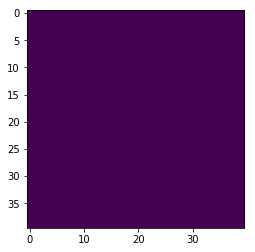

In [13]:

w = 40
h = 40
n = w*h

obs = np.zeros((h,w))

for _ in range(0):
    l = np.random.randint(7,20)
    i = np.random.randint(env.shape[0])
    j = np.random.randint(env.shape[1])
    if np.random.sample() < 0.5:
        obs[i,j:j+l] = 1
    else:
        obs[i:i+l,j] = 1

        
plt.imshow(-obs)
plt.show()


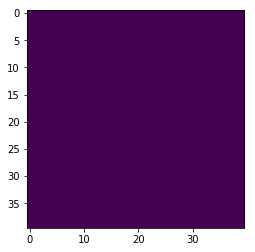

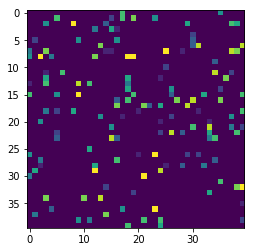

In [14]:
num_features = 10
env = np.zeros((h,w))
# 1 left
# 2 right
# 3 top
# 4 bottom
# env[np.where(np.roll(obs, ( 0,  1), axis=[0,1])==1)] = 1
# env[np.where(np.roll(obs, ( 0, -1), axis=[0,1])==1)] = 2
# env[np.where(np.roll(obs, ( 1,  0), axis=[0,1])==1)] = 3
# env[np.where(np.roll(obs, (-1,  0), axis=[0,1])==1)] = 4


for f in range(1,num_features+1):
    f_prob =  0.01
    env[np.where(np.random.sample((40,40)) < f_prob)] = f




env[np.where(obs==1)] = 0

plt.imshow(-obs)
plt.show()
plt.imshow(env)

In [16]:
"""
Creating an environment and 
a path of an agent
"""
from htmresearch.support.gridcells.random_walk import smooth_torus_walk, explore_environment




num_steps = 100000
# X, _ = smooth_torus_walk(num_steps, start=[0.5,0.5], min_speed=0.02, max_speed=0.055, sigma=12.5)

# X[:,0] *= (env.shape[0] )
# X[:,1] *= (env.shape[1] )
# X = X.astype(int)

X = explore_environment(num_steps, obs)

# X_ = explore_environment(3*num_steps, obs)
# X = X_[np.arange(3*num_steps, step=3)]
print X.shape
Tr = np.zeros((n,n)) + 0.00001
Tr = Tr.reshape((w,h, w,h))
for t in range(1, num_steps):
    Tr[X[t-1,0],X[t-1,1],X[t,0],X[t,1]] += 1.
    
Tr = Tr.reshape((n,n))
# np.fill_diagonal(Tr, 0.)
Tr = Tr/np.sum(Tr, axis=0, keepdims=True)

(100000, 2)


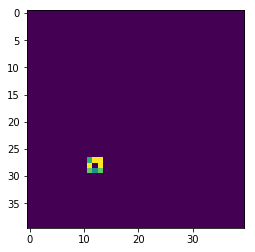

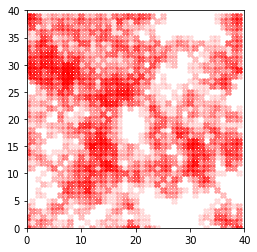

In [17]:
Tr_ = Tr
# Tr_ = np.dot(Tr,Tr)
plt.imshow(Tr_[:,1132].reshape((40,40)))
plt.show()


plt.xlim(0,w)
plt.ylim(0,h)

plt.imshow(obs, cmap="binary")
plt.scatter(X[:5000,1],X[:5000,0], c="red" ,alpha=0.1, marker="X")

(10, 40, 40, 5, 5)


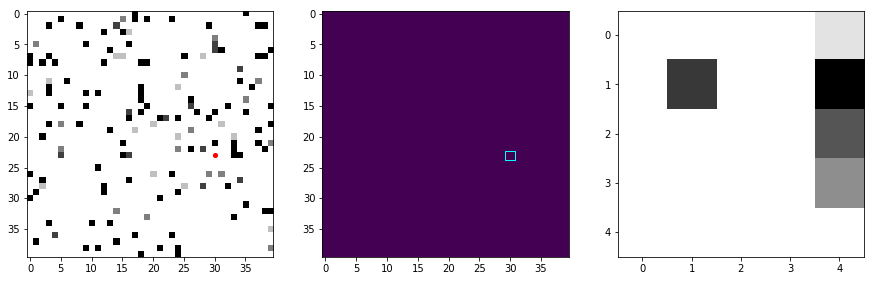

[[ 0.000625  0.000625  0.000625 ...,  0.000625  0.000625  0.000625]
 [ 0.000625  0.000625  0.000625 ...,  0.000625  0.000625  0.000625]
 [ 0.000625  0.000625  0.000625 ...,  0.000625  0.000625  0.000625]
 ..., 
 [ 0.000625  0.000625  0.000625 ...,  0.000625  0.000625  0.000625]
 [ 0.000625  0.000625  0.000625 ...,  0.000625  0.000625  0.000625]
 [ 0.000625  0.000625  0.000625 ...,  0.000625  0.000625  0.000625]]


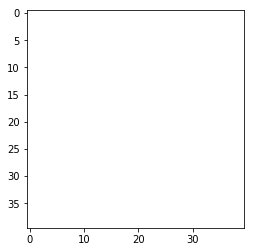

In [18]:
from htmresearch.support.gridcells.loc_utils import create_env_nbh_tensor,position_estimate_2




r = 2
T = 200

nbh_tensor    = create_env_nbh_tensor(env, r, num_features)
heatmap_agent = np.zeros((h,w))
positions  = []
heat_agent = []
nbhs    = []
probs      = []

P = np.zeros((T,env.shape[0], env.shape[1]))
P[:,:,:] = 1./np.prod(env.shape)
Q = np.ones((T,env.shape[0], env.shape[1]))/np.prod(env.shape)
Prior = np.ones((T,env.shape[0], env.shape[1]))/np.prod(env.shape)

print nbh_tensor.shape

for t in range(1,T):

    pos = X[t] 
    positions.append(pos.copy())
    
    heatmap_agent *= 0.98
    heatmap_agent[pos[0],pos[1]] = 1
    
    heat_agent.append(heatmap_agent.copy())
    
    f_id = int(env[pos[0],pos[1]])


    
    
    sub_0 = [i%h for i in range(pos[0] - r, pos[0]+r+1)]
    sub_1 = [i%w for i in range(pos[1] - r, pos[1]+r+1)]
    nbh = env[sub_0]
    nbh = nbh[:,sub_1]
    nbhs.append(nbh)

    if f_id > 0:
        nbh[np.where(nbh != f_id)] = 0
        nbh[np.where(nbh == f_id)] = 1

#         P[t,:,:] = position_estimate_2(nbh_tensor[f_id], nbh, r )
        fmap = (env == f_id).astype(float)
        P[t,:,:] = fmap/np.sum(fmap)
        
        Q[t,:,:] = Prior[t-1]*P[t] 
        Q[t,:,:] = Q[t,:,:]/np.sum(Q[t])
    else:
        Q[t,:,:] = Prior[t-1]
        
#     Prior[t,:,:] = np.dot(Tr, Q[t].reshape(-1)).reshape(env.shape) + 1./np.prod(env.shape)
    Prior[t,:,:] = np.dot(Tr, Q[t].reshape(-1)).reshape(env.shape) 
    Prior[t,:,:] = Prior[t,:,:]/np.sum(Prior[t,:,:])
#     Prior[t,:,:] = (Prior[t,:,:] > 0.).astype(float)


    
t=10
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False, figsize=(15, 5))
ax2.imshow(P[t])  
ax2.scatter(X[t,1], X[t,0], marker="s", s=90, edgecolor="cyan", color="None")  

ax1.imshow(env, cmap="binary", vmin=0, vmax=4)
ax1.scatter(X[t,1],X[t,0], s=10, marker="o", c="red", edgecolor='red',  lw = 2)

ax3.imshow(nbhs[t], cmap="binary")
plt.show()
plt.imshow(P[t], cmap="binary")
print P[t]

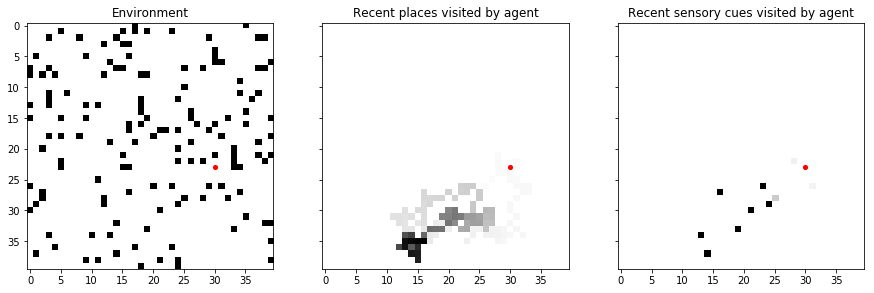

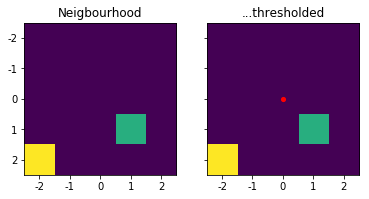

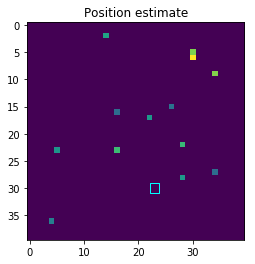

In [19]:

#     movie_frames.append(diffusion(prob))
        
# Two subplots, unpack the axes array immediately

f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15, 5))

ax1.set_title('Environment')
ax1.imshow(env, cmap="binary", vmin=0, vmax=1)
ax1.scatter(X[t,1],X[t,0], s=10, marker="o", c="red", edgecolor='red',  lw = 2)
ax2.set_title('Recent places visited by agent')
ax2.imshow(heatmap_agent, cmap="binary", vmin=0, vmax=1)
ax2.scatter(X[t,1],X[t,0], s=10, marker="o", c="red", edgecolor='red',  lw = 2)
ax3.set_title("Recent sensory cues visited by agent")
ax3.imshow(heatmap_agent*env, cmap="binary", vmin=0, vmax=1)
ax3.scatter(X[t,1],X[t,0], s=10, marker="o", c="red", edgecolor='red',  lw = 2)
plt.show()



nbh = nbhs[-1]

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(6, 5))
ax1.set_title("Neigbourhood")
ax1.imshow(nbh)
ax1.set_xticks(range(2*r +1))
ax1.set_xticklabels(range(-r, r+1))
ax1.set_yticks(range(2*r +1))
ax1.set_yticklabels(range(-r, r+1))


ax2.set_title("...thresholded")
ax2.imshow(nbh)
ax2.scatter(r,r, s=10, marker="o", c="red", edgecolor='red',  lw = 2)
ax2.set_xticks(range(2*r +1))
ax2.set_xticklabels(range(-r, r+1))
ax2.set_yticks(range(2*r +1))
ax2.set_yticklabels(range(-r, r+1))

plt.show()


# nbh = CL.decode_bw(r, threshold=0.7, softmax=True)



# plt.title("Reconstruction.. thresholded")
# plt.imshow(nbh)
# plt.scatter(r,r, s=10, marker="o", c="red", edgecolor='red',  lw = 2)
# plt.xticks(range(2*r +1), range(-r, r+1))
# plt.yticks(range(2*r +1), range(-r, r+1))
# plt.show()



plt.title("Position estimate")
plt.imshow(Q[t-3])
plt.scatter(X[t,0], X[t,1], marker="s", s=90, edgecolor="cyan", color="None")  
plt.show()




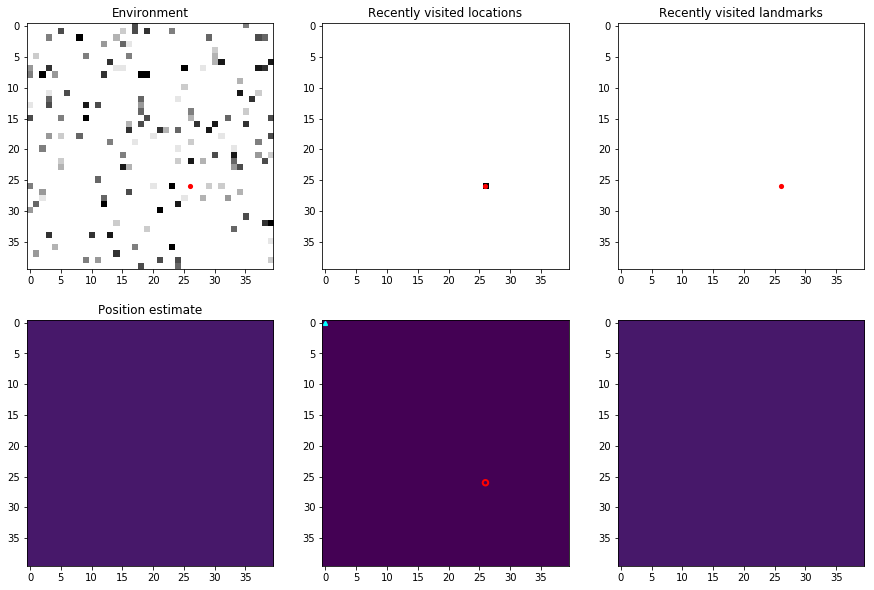

In [20]:
# First set up the figure, the axis, and the plot element we want to animate



fig, ax = plt.subplots(2, 3, figsize=(15, 10));


p = positions[0]
ax[0,0].set_title("Environment")
im1 = ax[0,0].imshow(obs + 0.05*env, cmap="binary", animated=True)
sc1 = ax[0,0].scatter(p[1],p[0], s=10, marker="o", c="red", edgecolor='red',  lw = 2)

ax[0,1].set_title("Recently visited locations")
im2 = ax[0,1].imshow(heat_agent[10], cmap="binary", vmin=0, vmax=1)
sc2 = ax[0,1].scatter(p[0],p[1], s=10, marker="o", c="red", edgecolor='red',  lw = 2)

ax[0,2].set_title("Recently visited landmarks")
im3 = ax[0,2].imshow(heatmap_agent*env, cmap="binary", vmin=0, vmax=1)
sc3 = ax[0,2].scatter(X[t,1],X[t,0], s=10, marker="o", c="red", edgecolor='red',  lw = 2)


ax[1,0].set_title("Position estimate")
# im4 = ax[1,0].imshow(probs[-1], cmap="viridis", animated=True)
im4 = ax[1,0].imshow(Q[t], cmap="viridis", vmin=0, vmax=0.01, animated=True)
# sc4 = ax[1,0].scatter(p[0],p[1], s=10, marker="o", c="red", edgecolor='red',  lw = 2)

args = np.where(Q[t] >= np.sort(Q[t].reshape(-1))[-1])
Est = np.stack(args, axis=0)

im5 = ax[1,1].imshow(np.zeros(env.shape), cmap="viridis", vmin=0, vmax=0.01, animated=True)
sc5 = ax[1,1].scatter(X[t,1],X[t,0], s=30, marker="o", c="None", edgecolor='red',  lw = 2)
sc5_ = ax[1,1].scatter(Est[0,0],Est[1,0], s=10, marker="^", c="cyan", edgecolor='cyan',  lw = 2)


im6 = ax[1,2].imshow(P[t], cmap="viridis", vmin=0, vmax=0.01, animated=True)
    
# animation function. This is called sequentially
def animate(i):
#     positions  
#     heat_agent 
#     nbh_rec    
    p = positions[i]

    im1.set_array(obs + 0.05*env)
    sc1.set_offsets(p[::-1])
    im2.set_array(heat_agent[i])
    sc2.set_offsets(p[::-1])
    im3.set_array(heat_agent[i]*env)
    sc3.set_offsets(p[::-1])
    
    prob = Q[i]
    im4.set_array(prob)
    
    args = np.where(Q[i] >= np.sort(Q[i].reshape(-1))[-1])
    Est = np.stack(args, axis=0)
    
    sc5.set_offsets(p[::-1])
    sc5_.set_offsets(Est[::-1,0])
    
    
    im6.set_array(P[i])


    return []


# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate,
                               frames=T-1, interval=200, blit=True)



In [21]:
HTML(anim.to_html5_video())